In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [ ]:
#df = pd.DataFrame
from ipynb.fs.full.my_functions import process_data
df = process_data()

In [ ]:
ax = df['Gen_RPM'].value_counts().head(10).plot(kind='bar', title='Top Gen_RPM speed')

In [ ]:
df.query('Gen_Bear_Temp > 92')['Gen_Bear_Temp'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')
plt.show()

In [ ]:
train = df.loc[df.index < '2017']
test = df.loc[df.index >= '2017-06']
cv = df.loc[(df.index > '2017') & (df.index < '2017-06')]

fix, ax = plt.subplots(figsize=(15,5))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Validation/Test Split')
cv.Gen_Bear_Temp.plot(ax=ax, label='Cross Validation Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.axvline('2017-06', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
#ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
plt.show()

In [ ]:
train = df.loc[df.index < '2017']
test = df.loc[df.index >= '2017']

fix, ax = plt.subplots(figsize=(15,5))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
plt.show()

In [8]:
FEATURES = ['Gen_RPM', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Gen_Phase_Temp']
TARGET = 'Gen_Bear_Temp'

df = process_data()
train = df.loc[df.index < '2017'].copy()
test = df.loc[df.index >= '2017'].copy()
cv = df.loc[(df.index > '2017') & (df.index < '2017-06')]

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:44.97439	validation_1-rmse:46.10404
[100]	validation_0-rmse:16.70799	validation_1-rmse:17.03738
[200]	validation_0-rmse:6.46886	validation_1-rmse:6.55312
[300]	validation_0-rmse:2.97767	validation_1-rmse:3.07460
[400]	validation_0-rmse:1.99616	validation_1-rmse:2.19356
[500]	validation_0-rmse:1.75287	validation_1-rmse:2.01594
[600]	validation_0-rmse:1.67617	validation_1-rmse:1.94820
[700]	validation_0-rmse:1.63333	validation_1-rmse:1.92602
[780]	validation_0-rmse:1.60997	validation_1-rmse:1.93028


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

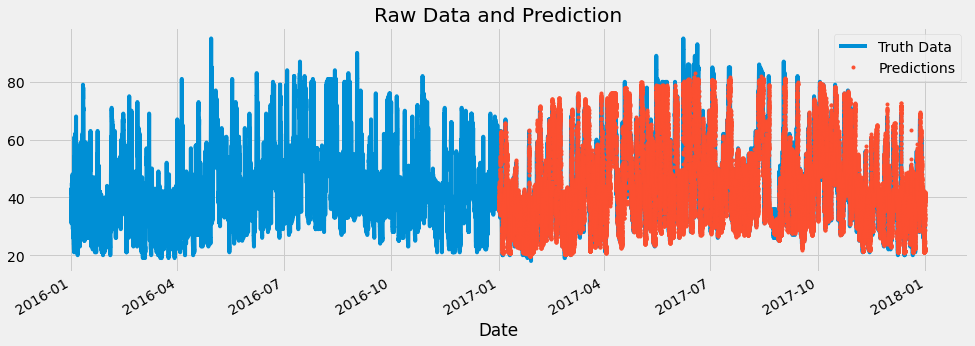

In [10]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True).copy()
ax = df[['Gen_Bear_Temp']].plot(figsize=(15, 5))
df.prediction.plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [23]:
X_test.head(3)

,Gen_RPM,Nac_Temp,Wind_Speed,Humidity,Gen_Phase_Temp
Date,,,,,
2017-01-01 00:00:00,1336.5,25.0,6.0,66.0,58.0
2017-01-01 00:10:00,1307.9,25.0,5.7,66.0,58.0
2017-01-01 00:20:00,1325.9,24.0,5.9,67.0,58.0


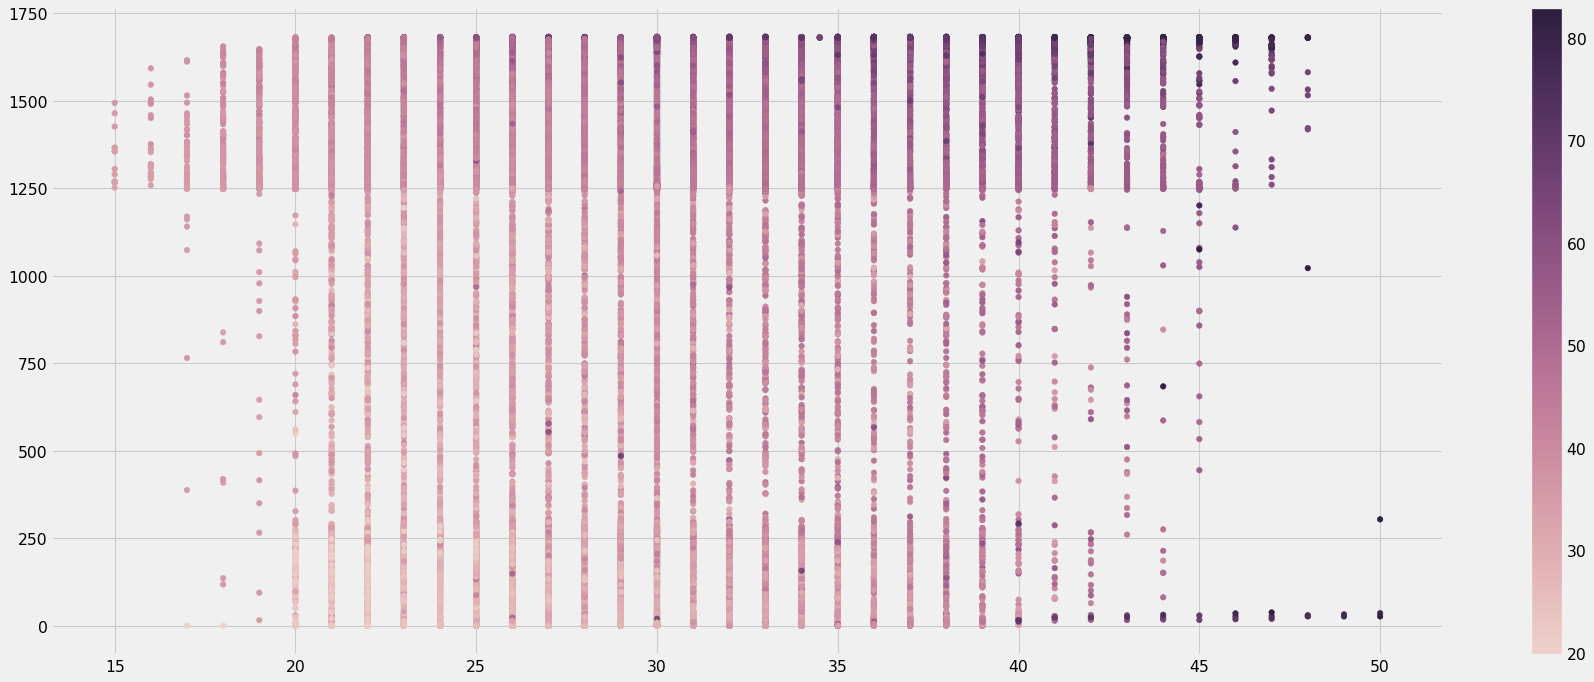

In [24]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(X_test.iloc[:, ], X_test.iloc[:, 0], c=test.prediction, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

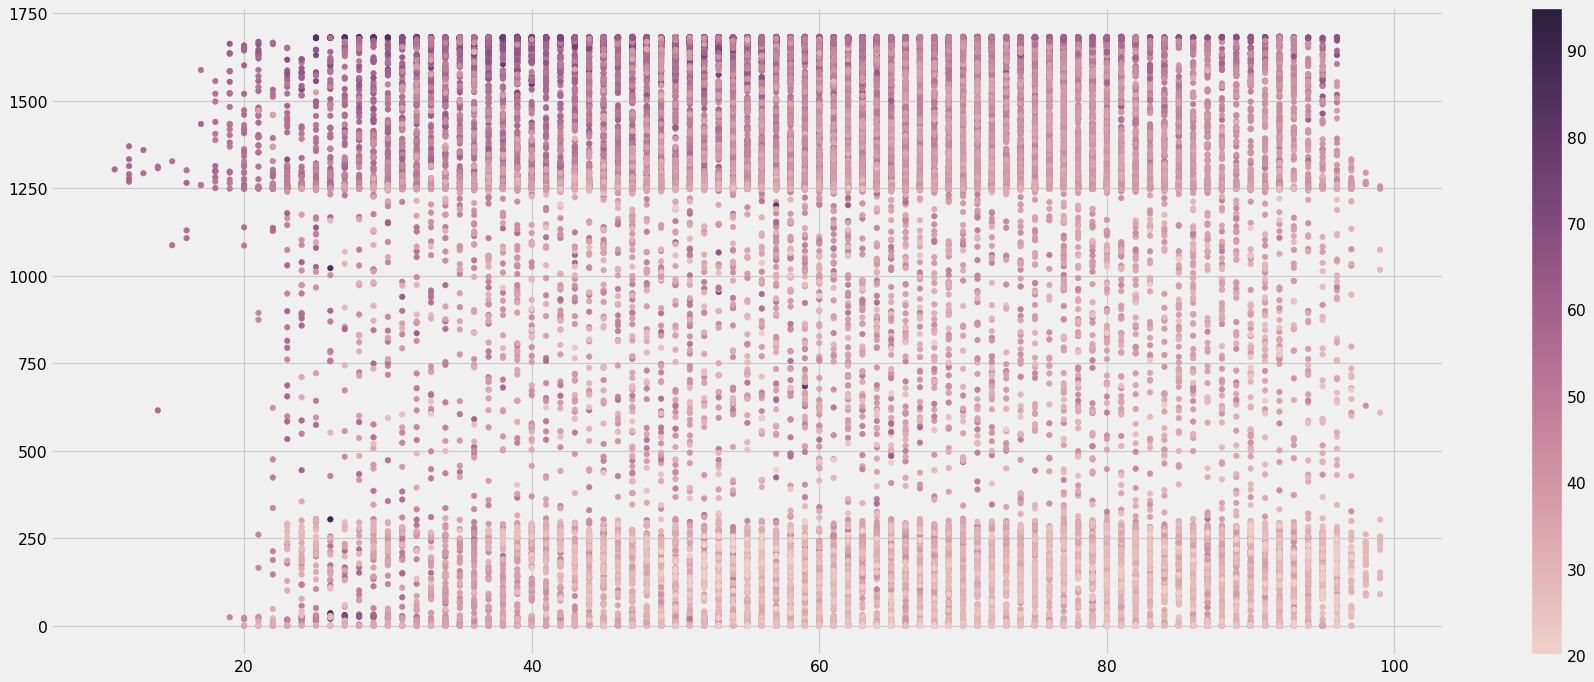

In [22]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(X_test.iloc[:, 3], X_test.iloc[:, 0], c=y_test, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
ax = future_w_features.loc[(future_w_features.index > '2017-06-03') & (future_w_features.index < '2017-09-12')]['Gen_Bear_Temp'] \
    .plot(figsize=(15, 5), title='Week Of Data')
future_w_features.loc[(future_w_features.index > '2017-06-03') & (future_w_features.index < '2017-09-12')]['pred'] \
    .plot(style='.')
# (df.loc[(df.index > '2017-06-03') & (df.index < '2017-06-12')]['prediction'] + np.std(df.prediction)) \
#      .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
ax = df.loc[(df.index > '2017-06-03') & (df.index < '2017-06-12')]['Gen_Bear_Temp'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2017-06-03') & (df.index < '2017-06-12')]['prediction'] \
    .plot(style='.')
# (df.loc[(df.index > '2017-06-03') & (df.index < '2017-06-12')]['prediction'] + np.std(df.prediction)) \
#      .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
# Fits the explainer
explainer = shap.Explainer(reg.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

In [ ]:
shap.plots.waterfall(shap_values[20000])

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"Gen_RPM"])

In [ ]:
reg.predict(np.array([0.2, -70.0, 1.0, 47.0, 100]).reshape(1,-1))

In [ ]:
df.Gen_Bear_Temp.loc[(df.index > '01-01-2016') & (df.index < '01-08-2016')].plot()

In [ ]:
score = np.sqrt(mean_squared_error(test['Gen_Bear_Temp'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

In [ ]:
tss = TimeSeriesSplit(n_splits=6, test_size=6*24*30, gap=6*24)

fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)

CV = df.loc[df.index < '2017-06'].copy()
fold = 0
for train_idx, val_idx in tss.split(CV):
    train = CV.iloc[train_idx]
    test = CV.iloc[val_idx]
    train['Gen_Bear_Temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Gen_Bear_Temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=6*24*30, gap=6*24)

CV = df.loc[df.index < '2017-06'].copy()
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(CV):
    train = CV.iloc[train_idx]
    test = CV.iloc[val_idx]
    
    FEATURES = ['Gen_RPM', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Gen_Phase_Temp']
    TARGET = 'Gen_Bear_Temp'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

In [ ]:
future_df = df.loc[df.index >= '2017'].copy()
future_df['isFuture'] = True
df['isFuture'] = False
CV_and_future = pd.concat([df, future_df])

In [ ]:
future_w_features = CV_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
future_w_features

In [ ]:
from PyALE import ale

In [ ]:
X = df.copy()
model = reg
features = FEATURES

## 1D - continuous - no CI
ale_eff = ale(
    X=X[features], model=model, feature=["Gen_RPM"], grid_size=50, include_CI=False
)

In [ ]:
## 1D - continuous - with 95% CI
import random
random.seed(123)
X_sample = X_train[features].loc[random.sample(X.index.to_list(), 1000), :]
ale_eff = ale(
    X=X_sample, model=model, feature=["Wind_Speed"], grid_size=50, include_CI=True, C=0.95
)

In [ ]:
ale_eff = ale(X=X[features], model=model, feature=["Nac_Temp", "Gen_RPM"], grid_size=100)

In [ ]:
reg.score(X_test, y_test)

In [ ]:
cv = TimeSeriesSplit(n_splits=5, test_size=6*24*30, gap=6*24)
X = df[FEATURES]
y = df[TARGET]
scores = cross_val_score(reg, X, y, cv=cv, fit_params={X_train, y_train})


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Wind_Speed, lags=23, missing='drop', title='Wind Speed Autocorrelation')
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df.Wind_Speed, lags=23, title='Wind Speed Partial Autocorrelation')

In [ ]:
prev_co2_value = df.Wind_Speed.shift()
differenced_co2 = df.Wind_Speed - prev_co2_value
differenced_co2.plot()

In [ ]:
df

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

# fit the model
my_rf = HistGradientBoostingRegressor()
my_rf.fit(X_train, y_train)

test['preds'] = my_rf.predict(X_test)
df = df.merge(test[['preds']], how='left', left_index=True, right_index=True).copy()
ax = df[['Gen_Bear_Temp']].plot(figsize=(15, 5))
df['preds'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
start = '2017-06-07'
end = '2017-06-12'

# '2017-06-03'
# '2017-06-12'

ax = df.loc[(df.index > start) & (df.index < end)]['Gen_Bear_Temp'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > start) & (df.index < end)]['preds'] \
    .plot(style='.')
df.loc[(df.index > start) & (df.index < end)]['prediction'] \
    .plot(style='.')

plt.legend(['Measured','HGBR', 'XGB'])
plt.show()

In [ ]:
df.query('Humidity < 13')

In [ ]:
y.shape